In [1]:
import gurobi_manager

gurobi_manager.options = {
    'WLSACCESSID': '023dd6c9-cfb8-4f1b-a33c-77f3682d6631',
    'WLSSECRET': 'd7d09c3c-39c0-42dd-9f4d-4fae36615968',
    'LICENSEID': 2589125
}

In [2]:
import networkx as nx
import torch
from tqdm import tqdm

from dql import DQGN, Agent

from graph import milp_solve_mds, generate_graphs

In [3]:
n, p = 100, .15
tt_g = 1000
graphs = generate_graphs(range(n, n+1), p, s=tt_g, solver=milp_solve_mds, attrs=['dominable_neighbors'])

Sampling 1000 instances from G(range(100, 101), 0.15)...


100%|██████████| 1000/1000 [13:55<00:00,  1.20graph/s]


In [4]:
ckp_path = './experiments/2024-12-18-1105/version_0/checkpoints/epoch=1039-step=1040.ckpt'
device = torch.device('cpu')
checkpoint = torch.load(ckp_path, map_location=device)
hyper_parameters = checkpoint['hyper_parameters']

state_dict = {k.replace('net.', ''): v for k, v in checkpoint['state_dict'].items() if 'target' not in k}
state_dict.pop('loss_module.pos_weight', None)

c_in = graphs[0].x.shape[1]
gnn = DQGN(c_in=c_in)
gnn.load_state_dict(state_dict)
gnn.eval()
gnn

DQGN(
  (layers): ModuleList(
    (0): GCNConv(2, 64)
    (1): ReLU(inplace=True)
    (2): GCNConv(64, 64)
    (3): ReLU(inplace=True)
    (4): GCNConv(64, 64)
    (5): ReLU(inplace=True)
    (6): GCNConv(64, 64)
    (7): ReLU(inplace=True)
    (8): GCNConv(64, 64)
    (9): ReLU(inplace=True)
    (10): GCNConv(64, 64)
    (11): ReLU(inplace=True)
    (12): GCNConv(64, 64)
    (13): ReLU(inplace=True)
    (14): GCNConv(64, 64)
    (15): ReLU(inplace=True)
    (16): GCNConv(64, 64)
    (17): ReLU(inplace=True)
  )
  (node_transform): Linear(in_features=64, out_features=64, bias=False)
  (neig_transform): Linear(in_features=64, out_features=64, bias=False)
  (aggr_transform): Linear(in_features=128, out_features=1, bias=False)
  (relu): ReLU(inplace=True)
  (tanh): Tanh()
)

In [5]:
agent = Agent(n, p, None, None, None, graphs)

In [6]:
valid_ds = []
size_eq_lp = []
apx_ratio = []
gap = []
opt_sizes = []
s_sizes = []

print(f'testing agent on mds')
for g in tqdm(graphs, unit='graph'):
    agent.reset(g)
    # Perform an episode of actions
    for step in range(n):
        rwd, done = agent.play_validation_step(gnn, 'cpu')
        if done:
            break
    g.s = {i for i, v in enumerate(agent.state.x[:, 0]) if v == 1}

    valid_ds.append(all(v in g.s or len(g.nx[v].keys() & g.s) > 0 for v in g.nx))
    len_opt = sum(v for v in g.y)
    size_eq_lp.append(len(g.s) <= len_opt)
    apx_ratio.append(len(g.s)/len_opt)
    gap.append(len_opt/len(g.s))
    opt_sizes.append(len_opt)
    s_sizes.append(len(g.s))

testing agent on mds


100%|██████████| 1000/1000 [03:12<00:00,  5.21graph/s]


In [7]:
valid_ds = 100*sum(valid_ds)/tt_g
size_eq_lp = (100*sum(size_eq_lp)/tt_g).item()
apx_ratio = (sum(apx_ratio)/tt_g).item()
gap = (1-sum(gap)/tt_g).item()
avg_opt_size = (sum(opt_sizes)/tt_g).item()
avg_s_size = sum(s_sizes)/tt_g
print(f'{"valid DS"}{"S <= OPT":>14}{"apx ratio":>14}{"gap":>14}{"μ|OPT|":>14}{"μ|S|":>14}')
print(f'{valid_ds:>7}%{size_eq_lp:>13.1f}%{apx_ratio:>14.3f}{gap:>14.3f}{avg_opt_size:>14.1f}{avg_s_size:>14.1f}')

valid DS      S <= OPT     apx ratio           gap        μ|OPT|          μ|S|
  100.0%         16.5%         1.802         0.332          13.6          21.8


In [8]:
g_gen = (g for g in graphs if len(g.s) == len([i for i in g.y if i]))

g.s={32, 97, 66, 98, 5, 10, 11, 12, 92, 17, 86, 58, 28, 93, 63} y={2, 35, 66, 5, 98, 11, 17, 49, 82, 86, 23, 57, 58, 93, 95}


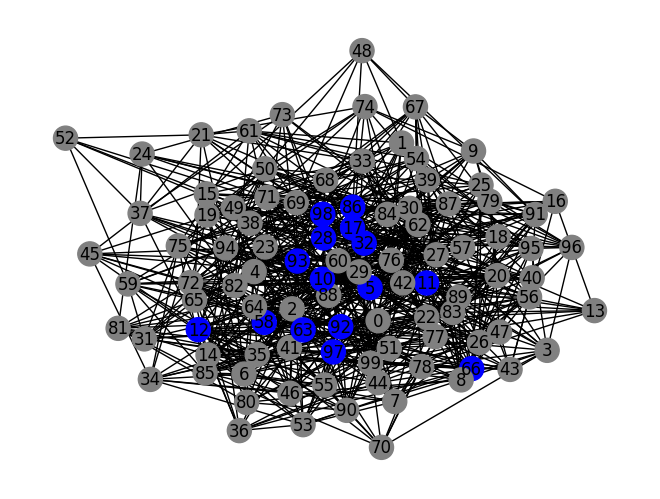

In [9]:
g = next(g_gen)
g_n = g.nx

try:
    layout = nx.planar_layout(g_n)
except:
    layout = nx.drawing.spring_layout(g_n)

node_colors = ['blue' if n in g.s else 'gray' for n in g.nx]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout)
y = {i for i, v in enumerate(g.y) if v}
print(f'{g.s=} {y=}')

In [10]:
edge_index, node_feats = g.edge_index, torch.FloatTensor([[0]] * n)
q_values = gnn(node_feats, edge_index).squeeze().tolist()
sorted(enumerate(q_values), key=lambda qv: qv[1], reverse=True)

TypeError: forward() missing 1 required positional argument: 'nb_batch'

In [ ]:
edge_index, node_feats = g.edge_index, torch.FloatTensor([[1], [0], [1], [1], [0], [0], [0], [0], [0], [0]])
q_values = gnn(node_feats, edge_index).squeeze().tolist()
sorted(enumerate(q_values), key=lambda qv: qv[1], reverse=True)